In [7]:
pip install keybert 

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [40]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords
import nltk
import re
import emoji
from keybert import KeyBERT
from sentence_transformers import SentenceTransformer
from sklearn.utils import resample

In [9]:
data = pd.read_csv("data/shortjokes.csv" , index_col=0)

In [10]:
data.head(10)

,Joke
ID,
1,"[me narrating a documentary about narrators] ""..."
2,Telling my daughter garlic is good for you. Go...
3,I've been going through a really rough period ...
4,"If I could have dinner with anyone, dead or al..."
5,Two guys walk into a bar. The third guy ducks.
6,Why can't Barbie get pregnant? Because Ken com...
7,Why was the musician arrested? He got in treble.
8,Did you hear about the guy who blew his entire...
9,What do you do if a bird shits on your car? Do...


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 231657 entries, 1 to 231657
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Joke    231657 non-null  object
dtypes: object(1)
memory usage: 3.5+ MB


In [12]:
data.isna().sum()

Joke    0
dtype: int64

#### Nettoyage du texte 

In [13]:
# Fonction pour le nettoyage du texte
def clean_text(text):
    if not isinstance(text, str):
        return ""

    # Convertir en minuscules
    text = text.lower()
    
    # Supprimer les emojis et le remplacer par des espaces
    text = emoji.replace_emoji(text, replace='')  

    # Supprimer les URL
    text = re.sub(r'http\S+|www\S+', '', text)
    
    # Supprimer les caractères spéciaux sauf la ponctuation pertinente
    text = re.sub(r"[^a-zA-Z0-9\s!?.,']", "", text)
    
    # Supprimer les espaces en trop
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

In [14]:
# Nettoyer la colonne "Joke"
data["Joke_Cleaned"] = data["Joke"].apply(clean_text)

# Afficher un aperçu des blagues nettoyées
print(data[["Joke", "Joke_Cleaned"]].head())

                                                 Joke  \
ID                                                      
1   [me narrating a documentary about narrators] "...   
2   Telling my daughter garlic is good for you. Go...   
3   I've been going through a really rough period ...   
4   If I could have dinner with anyone, dead or al...   
5      Two guys walk into a bar. The third guy ducks.   

                                         Joke_Cleaned  
ID                                                     
1   me narrating a documentary about narrators i c...  
2   telling my daughter garlic is good for you. go...  
3   i've been going through a really rough period ...  
4   if i could have dinner with anyone, dead or al...  
5      two guys walk into a bar. the third guy ducks.  


#### Détection et suppression des doublons

In [15]:
# Vérifier le nombre de doublons exacts
nb_doublons_exact = data.duplicated(subset=["Joke_Cleaned"]).sum()
print(f"Nombre de blagues en double : {nb_doublons_exact}")

Nombre de blagues en double : 1493


In [16]:
# Supprimer les doublons exacts
data = data.drop_duplicates(subset=["Joke_Cleaned"], keep="first")

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 230164 entries, 1 to 231657
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   Joke          230164 non-null  object
 1   Joke_Cleaned  230164 non-null  object
dtypes: object(2)
memory usage: 5.3+ MB


#### Détection et suppression des valeurs manquantes 

In [18]:
nb_nan = data["Joke_Cleaned"].isna().sum()
nb_empty = (data["Joke_Cleaned"].str.strip() == "").sum()
print(f"Nombre de blagues NaN : {nb_nan}")
print(f"Nombre de blagues vides : {nb_empty}")

Nombre de blagues NaN : 0
Nombre de blagues vides : 1


Il existe une seule blague vide qu'on va supprimer

In [19]:
data = data.dropna(subset=["Joke_Cleaned"])
data = data[data["Joke_Cleaned"].str.strip() != ""]

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 230163 entries, 1 to 231657
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   Joke          230163 non-null  object
 1   Joke_Cleaned  230163 non-null  object
dtypes: object(2)
memory usage: 5.3+ MB


Normalisation du texte 

In [21]:
# Dictionnaire des abréviations courantes
abbreviations = {
    "u": "you",
    "r": "are",
    "ur": "your",
    "lol": "laughing out loud",
    "lmao": "laughing my ass off",
    "rofl": "rolling on the floor laughing",
    "idk": "i don't know",
    "omg": "oh my god",
    "thx": "thanks",
    "ty": "thank you",
    "plz": "please",
    "btw": "by the way"
}

In [22]:
def normalize_text(text):
    # Remplacer les abréviations par leur version complète
    words = text.split()
    words = [abbreviations[word] if word in abbreviations else word for word in words]
    text = " ".join(words)
    
    # Réduction des répétitions excessives 
    text = re.sub(r"(.)\1{2,}", r"\1\1", text)  
    
    return text

# Appliquer la normalisation sur la colonne "Joke_Cleaned"
data["Joke_Normalized"] = data["Joke_Cleaned"].apply(normalize_text)

In [23]:
data.head(10)

,Joke,Joke_Cleaned,Joke_Normalized
ID,,,
1,"[me narrating a documentary about narrators] ""...",me narrating a documentary about narrators i c...,me narrating a documentary about narrators i c...
2,Telling my daughter garlic is good for you. Go...,telling my daughter garlic is good for you. go...,telling my daughter garlic is good for you. go...
3,I've been going through a really rough period ...,i've been going through a really rough period ...,i've been going through a really rough period ...
4,"If I could have dinner with anyone, dead or al...","if i could have dinner with anyone, dead or al...","if i could have dinner with anyone, dead or al..."
5,Two guys walk into a bar. The third guy ducks.,two guys walk into a bar. the third guy ducks.,two guys walk into a bar. the third guy ducks.
6,Why can't Barbie get pregnant? Because Ken com...,why can't barbie get pregnant? because ken com...,why can't barbie get pregnant? because ken com...
7,Why was the musician arrested? He got in treble.,why was the musician arrested? he got in treble.,why was the musician arrested? he got in treble.
8,Did you hear about the guy who blew his entire...,did you hear about the guy who blew his entire...,did you hear about the guy who blew his entire...
9,What do you do if a bird shits on your car? Do...,what do you do if a bird shits on your car? do...,what do you do if a bird shits on your car? do...


Analyse exploratrice

       Joke_Length_Chars  Joke_Length_Words
count      230163.000000      230163.000000
mean           91.754496          17.541573
std            34.481412           6.846874
min             3.000000           1.000000
25%            65.000000          12.000000
50%            87.000000          17.000000
75%           117.000000          22.000000
max           255.000000          93.000000


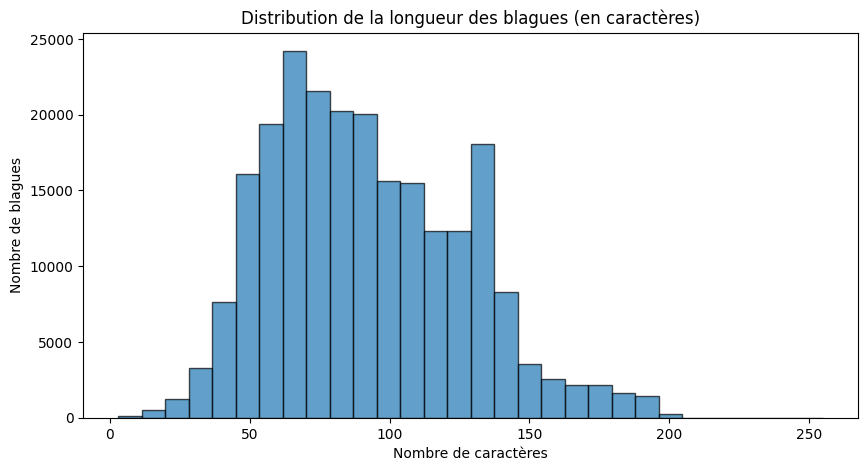

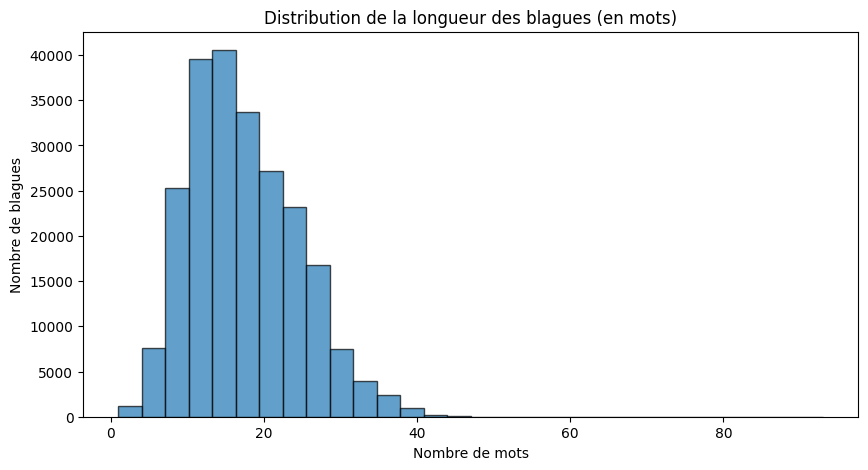

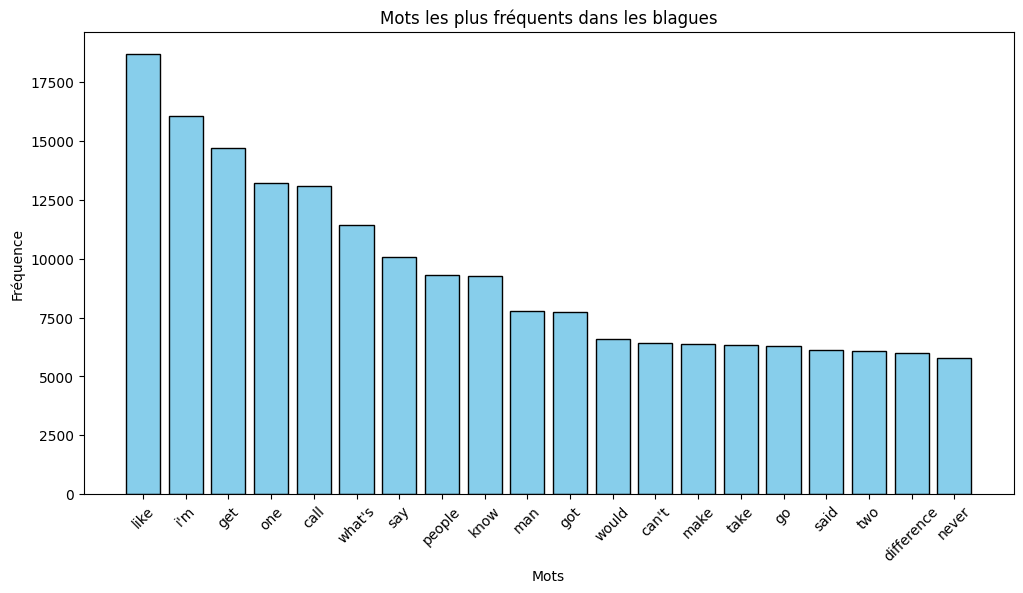

In [24]:
stop_words = set(stopwords.words('english'))

# Calcul de la longueur des blagues 
data["Joke_Length_Chars"] = data["Joke_Normalized"].apply(len)
data["Joke_Length_Words"] = data["Joke_Normalized"].apply(lambda x: len(x.split()))

# Afficher les statistiques de longueur
print(data[["Joke_Length_Chars", "Joke_Length_Words"]].describe())

# Distribution des longueurs en caractères
plt.figure(figsize=(10, 5))
plt.hist(data["Joke_Length_Chars"], bins=30, edgecolor="black", alpha=0.7)
plt.xlabel("Nombre de caractères")
plt.ylabel("Nombre de blagues")
plt.title("Distribution de la longueur des blagues (en caractères)")
plt.show()

# Distribution des longueurs en mots
plt.figure(figsize=(10, 5))
plt.hist(data["Joke_Length_Words"], bins=30, edgecolor="black", alpha=0.7)
plt.xlabel("Nombre de mots")
plt.ylabel("Nombre de blagues")
plt.title("Distribution de la longueur des blagues (en mots)")
plt.show()

# Identification des mots les plus fréquents 
all_words = " ".join(data["Joke_Normalized"]).split()
filtered_words = [word for word in all_words if word.lower() not in stop_words]

# Compter les occurrences des mots
word_counts = Counter(filtered_words)
most_common_words = word_counts.most_common(20)

# Affichage des mots les plus fréquents
words, counts = zip(*most_common_words)
plt.figure(figsize=(12, 6))
plt.bar(words, counts, color="skyblue", edgecolor="black")
plt.xticks(rotation=45)
plt.xlabel("Mots")
plt.ylabel("Fréquence")
plt.title("Mots les plus fréquents dans les blagues")
plt.show()

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 230163 entries, 1 to 231657
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Joke               230163 non-null  object
 1   Joke_Cleaned       230163 non-null  object
 2   Joke_Normalized    230163 non-null  object
 3   Joke_Length_Chars  230163 non-null  int64 
 4   Joke_Length_Words  230163 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 10.5+ MB


Annotation des blagues

In [29]:
# Télécharger les ressources NLTK
nltk.download("wordnet")

# Initialiser KeyBERT et SentenceTransformer
kw_model = KeyBERT("all-MiniLM-L6-v2")
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")

# Liste de mots offensants 
offensive_words = [
    "sex", "gender", "womanizer", "feminist", "chauvinist", "misogynist",
    "misandrist", "patriarchy", "matriarchy",
    
    "racism", "racist", "black", "white", "asian", "african", "indian",
    "nigger", "cracker", "slur", "latino", "hispanic", "jew", "antisemitic",
    "arab", "middle eastern", "xenophobia", "immigrant",
    
    "penis", "vagina", "breast", "boobs", "dick", "cock", "pussy", "butt",
    "anus", "testicle", "scrotum", "nipple", "semen", "sperm", "condom",
    "masturbate", "ejaculate", "rape", "molest", "abuse", "hooker", 
    "prostitute", "whore", "slut", "porn", "pornography", "fetish",
    "orgy", "orgasm", "clitoris", "labia", "erection", "virginity",
    
    "dumb", "idiot", "moron", "retard", "cripple",
    "gay", "lesbian", "homosexual", "bisexual", "transgender", 
    "queer", "homo", "tranny", "dyke", "fag", "pervert", 
    "harass", "molestation", "pedophile", "incest"
]

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Pc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [30]:
# Fonction pour extraire les mots-clés d'une blague
def extract_keywords(text):
    keywords = kw_model.extract_keywords(text, keyphrase_ngram_range=(1, 2), stop_words="english", top_n=5)
    return [kw[0] for kw in keywords]

In [31]:
# Fonction pour détecter si une blague est offensive
def detect_offensive(text):
    keywords = extract_keywords(text)
    return int(any(word in offensive_words for word in keywords))

In [32]:
# Appliquer l'annotation automatique
data["Offensive_Label"] = data["Joke_Normalized"].apply(detect_offensive)

In [33]:
# Sauvegarder le dataset annoté
data.to_csv("dataset_annotated.csv", index=False)

In [ ]:
data.head(10)

,Joke,Joke_Cleaned,Joke_Normalized,Joke_Length_Chars,Joke_Length_Words,Offensive_Label
ID,,,,,,
1,"[me narrating a documentary about narrators] ""...",me narrating a documentary about narrators i c...,me narrating a documentary about narrators i c...,91,15,0
2,Telling my daughter garlic is good for you. Go...,telling my daughter garlic is good for you. go...,telling my daughter garlic is good for you. go...,117,18,0
3,I've been going through a really rough period ...,i've been going through a really rough period ...,i've been going through a really rough period ...,120,23,0
4,"If I could have dinner with anyone, dead or al...","if i could have dinner with anyone, dead or al...","if i could have dinner with anyone, dead or al...",86,16,0
5,Two guys walk into a bar. The third guy ducks.,two guys walk into a bar. the third guy ducks.,two guys walk into a bar. the third guy ducks.,46,10,0
6,Why can't Barbie get pregnant? Because Ken com...,why can't barbie get pregnant? because ken com...,why can't barbie get pregnant? because ken com...,74,13,0
7,Why was the musician arrested? He got in treble.,why was the musician arrested? he got in treble.,why was the musician arrested? he got in treble.,48,9,0
8,Did you hear about the guy who blew his entire...,did you hear about the guy who blew his entire...,did you hear about the guy who blew his entire...,116,22,0
9,What do you do if a bird shits on your car? Do...,what do you do if a bird shits on your car? do...,what do you do if a bird shits on your car? do...,68,16,0


In [37]:
print(data['Offensive_Label'].value_counts())

Offensive_Label
0    222858
1      7305
Name: count, dtype: int64


On constate un déséquilibre entre les deux classes : le dataset contient 222 858 blagues non offensantes contre seulement 7 305 blagues offensantes. Pour remédier à cette disparité, nous allons appliquer un sous-échantillonnage (undersampling) en réduisant le nombre de blagues non offensantes afin d'obtenir un jeu de données plus équilibré.

In [42]:
# Appliquer le sous-échantillonnage

data_offensive = data[data["Offensive_Label"] == 1]
data_non_offensive = data[data["Offensive_Label"] == 0]

# Sous-échantillonnage des blagues non offensantes pour équilibrer les classes
data_non_offensive_sampled = resample(data_non_offensive, 
                                      replace=False, 
                                      n_samples=len(data_offensive), 
                                      random_state=42)

# Concaténer les deux datasets équilibrés
data_balanced = pd.concat([data_offensive, data_non_offensive_sampled])

In [43]:
# Sauvegarder le dataset annoté et équilibré
data_balanced.to_csv("dataset_annotated_balanced.csv", index=False)

In [45]:
data_balanced.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14610 entries, 73 to 192182
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Joke               14610 non-null  object
 1   Joke_Cleaned       14610 non-null  object
 2   Joke_Normalized    14610 non-null  object
 3   Joke_Length_Chars  14610 non-null  int64 
 4   Joke_Length_Words  14610 non-null  int64 
 5   Offensive_Label    14610 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 799.0+ KB


In [47]:
print(data_balanced['Offensive_Label'].value_counts())

Offensive_Label
1    7305
0    7305
Name: count, dtype: int64
